In [ ]:
# This is the basic proportional rate diffusion model from Palmer, Huk and Shadlen '05. 
# The overall fits are good for subject accuracies but mRT fits are not very good. 
# More specifically, the lowering of mRTs observed at low distance and high coherence 
# is not captured by the model.

# I am not imposing any constraints on the parameters (+ve or -ve) except to say that x is positive.

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import factorial as fact

In [2]:
# List subjects to fit
subs = ['Sub01', 'Sub02', 'Sub04', 'Sub05', 'Sub06', 'Sub08', 'Sub10', 'Sub11', 'Sub13']
nSub = len(subs)

# Initialize arrays to hold PC, mean and SD of RT, and # trials 
# for each coherence-distanct combination
# These values are obtained from the .csv files
pCs = np.zeros((20, nSub))
mRTs = np.zeros((20, nSub))
sdRTs = np.zeros((20, nSub))
Ns = np.zeros((20, nSub))

# Initialise a variable to hold # correct trials
# This will be computed from Ns and pCs
Rs = np.zeros((20, nSub))

In [3]:
# Extract behavioral data (PC, mean and SD of RT, # trials) from csv files
for si in range(nSub):
    csvFile = '../Data/Behavior/' + subs[si] + '_behavData.csv'
    behavData = pd.read_csv(csvFile, header=None)
    
    # Split the file in PC, mean RT and SD RT
    # Flatten each subject's values for ease of programming
    pCs[:,si] = np.array(behavData[0:4]).flatten()
    mRTs[:,si] = np.array(behavData[4:8]).flatten()
    sdRTs[:,si] = np.array(behavData[8:12]).flatten()
    Ns[:,si] = np.array(behavData[12:]).flatten()
    Rs[:,si] = np.round(Ns[:,si] * pCs[:,si])

In [ ]:
# Parameters to fit:
# A: Boundary
# x: Stimulus strength
# k: Proportionality constant (Stim. str. = kx)
# tR: Residual time

# Equations to fit for each stimulus strength:
# pC = 1 / (1+exp(-2*A*k*abs(x)))
# mRT = A / (k*x) * tanh(A*k*x) + tR

# We can get approximate values for A, k and tR from Palmer et. al. '05
# Ranges of parameters to start with:
# A: 0.5 - 1
# k: 5 - 40
# tR: 0.25 - 0.5 (in seconds)
# x: 0 - 1

# To identify best fit, calculate the likelihood of predicted pC and mRT and find the maximum likelihood.

# Likelihood of pC follows a binomial distribution
# Lp = n! / (r!(n-r)! * pC(x)^r * (1-pC(x))^(n-r), where
# n = # trials, r = # required correct

# Likelihood of mRT follows a Gaussian distribution
# Lrt = 1 / (SDrt * (sqrt(2*pi))) * e^-((mRT(x) - oRT(x)) / SDrt)^2 * 1/2, where
# oRT = observed mRT, mRT = predicted mRT, SDrt = SD of predicted mRT

# VARrt = VARtd + VARtr, where
# VARtd = variance in decision time, VARtr = variance in residual time. Thus,
# VARrt = (A * tanh(A*k*x) - A*k*x * sech(A*k*x)) / (k*x)^3 + (0.1 * tR)^2

# Final fit measure is the log likelihood, which is the sum of the likelihoods of accuracy and mean RT, 
# over all combinations of coherence and distance
# Lprt = sigma(x)(ln(Lp(s)) + ln(Lrt(x)))

# The first pass of the model will be to estimate values of x without any assumptions about stimulus relationtips.
# The stopping point will be the point of least error.

In [28]:
# Initialize A, k and tR parameters
A, dA = np.linspace(0.5, 5, 10, retstep=True)
# k, dk = np.linspace(0.3, 2, 20, retstep=True)
k, dk = np.linspace(0.01, 5, 10, retstep=True)
tR, dtR = np.linspace(0.01, 10, 20, retstep=True)

As, ks, tRs = np.meshgrid(A, k, tR)
As = As.flatten()
ks = ks.flatten()
tRs = tRs.flatten()

# This is the overall number of permutations of A, k and tR being performed
nPar = len(As)

# Initialize stimulus strength parameter
# x, dx = np.linspace(0.1, 10, 200, retstep=True)
x, dx = np.linspace(0.01, 10, 200, retstep=True)

# Initialize arrays that hold predicted accuracies and RTs
epc = np.ones((nPar, len(x), 20, 9)) * -9
ert = np.ones((nPar, len(x), 20, 9)) * -9
sdrt = np.ones((nPar, len(x), 20, 9)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc = np.zeros((nPar, len(x), 20, 9))
lrt = np.zeros((nPar, len(x), 20, 9))

In [29]:
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(20):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,:,cdi,si] = 1 / (1 + np.exp(-2 * As[pi] * ks[pi] * abs(x)))
            # And the likelihood of this accuracy
            lpc[pi,:,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,:,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,:,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,:,cdi,si] = As[pi] / (ks[pi] * x) * np.tanh(As[pi] * ks[pi] * x) + tRs[pi] 
            # And standard error of the mean
            sdrt[pi,:,cdi,si] = np.sqrt(((As[pi] * np.tanh(As[pi] * ks[pi] * x) - \
                    As[pi] * ks[pi] * x * (1/np.cosh(np.square(As[pi] * ks[pi] * x)))) / \
                    (ks[pi] * x) ** 3 + np.square(0.1 * tRs[pi])) / Ns[cdi,si])
            # And the likelihood of observing that RT
            lrt[pi,:,cdi,si] = 1 / (sdrt[pi,:,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,:,cdi,si] - mRTs[cdi,si]) / sdrt[pi,:,cdi,si]))

In [ ]:
# See if there are any weird PC, mRT or sdrt values generated in the parameter space
print(np.sum(np.isinf(epc)))
print(np.sum(np.isnan(epc)))
print(np.sum(epc < 0))
print(np.sum(np.isinf(ert)))
print(np.sum(np.isnan(ert)))
print(np.sum(ert < 0))
print(np.sum(np.isinf(sdrt)))
print(np.sum(np.isnan(sdrt)))
print(np.sum(sdrt < 0))

In [ ]:
# Find indices where sdrt is NaN (or, variance is negative)
tmpId = np.where(np.isnan(sdrt))[0]
sdIdx = np.unravel_index(tmpId, sdrt.shape)

# Find the fraction of trials that have NaN sdrt - 0.0134
print(len(sdIdx[0])/np.double(np.prod(sdrt.shape)))

# First see if it's any specific subjects that show this effect - no
print(np.unique(sdIdx[3]))
for i in range(nSub):
    print(np.sum(sdIdx[3] == i))

# Any specific CD combinations - no
print(np.unique(sdIdx[2]))
for i in range(20):
    print(np.sum(sdIdx[2] == i))

# Any specific x's - smaller ones
print(np.unique(sdIdx[1]))
for i in range(len(x)):
    print(np.sum(sdIdx[1] == i))

# Any specific A-k-tR combinations - first one
print(np.unique(sdIdx[0]))

In [30]:
bestXcd = np.ones((nPar, 20, nSub), dtype = np.int) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        bestXcd[pi,:,si] = np.argmax(lpc[pi,:,:,si], 0)
        for cdi in range(20):
            # Sum over all CDs to obtain overall likelihood for the 
            # give A-k-tR combination
            totLL[pi,si] += np.log(lpc[pi,bestXcd[pi,cdi,si],cdi,si])

In [ ]:
sortedLLidx = np.argsort(totLL,0)
print(totLL[sortedLLidx[0:10,1],1])

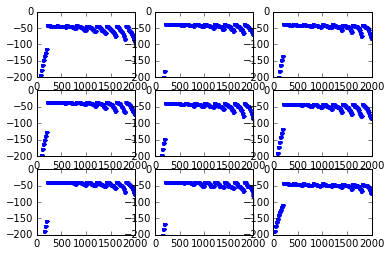

In [31]:
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    plt.ylim(-200, 0)

In [32]:
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

# Record the values of best fit x for each CD combination
bestx = np.zeros((20, nSub), dtype = np.int)

for si in range(nSub):
    ids = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    if len(ids) > 1:
        maxParId[si] = ids[0]
    else:
        maxParId[si] = ids
    bestx[:,si] = bestXcd[maxParId[si],:,si]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])

In [33]:
for si in range(nSub):
    print(round(totLL[maxParId[si],si],ndigits=3))

-42.01
-37.438
-38.951
-34.968
-38.625
-40.04
-37.836
-37.874
-43.287


In [34]:
subXs = np.zeros((20, nSub))
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si]],ndigits=3), round(ks[maxParId[si]],ndigits=3), round(tRs[maxParId[si]],ndigits=3))
    print(np.reshape(x[bestx[:,si]].round(decimals=2),(4,5)))
    subXs[:,si] = x[bestx[:,si]].round(decimals=2)
    
np.savetxt('SubXs_all.csv', subXs, fmt = '%.2f', delimiter = ',')

(1.0, 0.564, 0.01)
[[  0.01   0.01   0.11   0.01   0.01]
 [  0.01   0.06   0.61   0.56   1.06]
 [  0.01   0.86   1.47   1.77   2.57]
 [  0.01   1.27   3.27  10.    10.  ]]
(1.0, 0.564, 0.01)
[[  0.11   0.01   0.21   0.21   0.11]
 [  0.01   0.56   2.12   2.12   1.52]
 [  0.16   0.91   3.02   3.37   3.42]
 [  0.16   1.21   3.42  10.    10.  ]]
(1.0, 0.564, 0.01)
[[  0.21   0.46   0.21   0.01   0.01]
 [  0.21   0.16   1.47   1.52   1.42]
 [  0.01   1.01   2.12   3.27   3.27]
 [  0.01   1.27   2.92   3.93  10.  ]]
(1.0, 0.564, 0.01)
[[  0.01   0.16   0.01   0.01   0.21]
 [  0.01   0.06   1.01   1.16   1.11]
 [  0.01   0.81   3.12   2.12  10.  ]
 [  0.01   1.42  10.    10.    10.  ]]
(0.5, 1.119, 0.01)
[[  0.01   0.01   0.01   0.01   0.06]
 [  0.01   0.56   1.42   1.67   1.21]
 [  0.01   1.27   2.67   2.27  10.  ]
 [  0.01   2.27   3.93   3.27  10.  ]]
(0.5, 1.119, 0.01)
[[  0.16   0.36   0.01   0.01   0.01]
 [  0.46   0.56   1.01   1.21   1.16]
 [  0.01   0.46   1.62   1.52   2.37]
 [  0.0

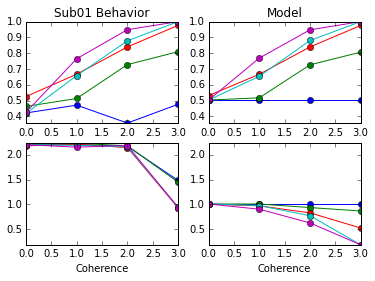

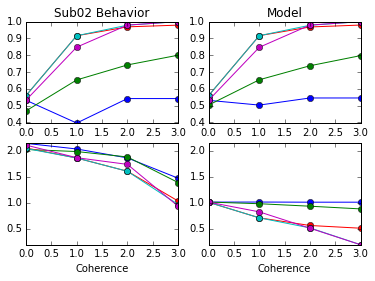

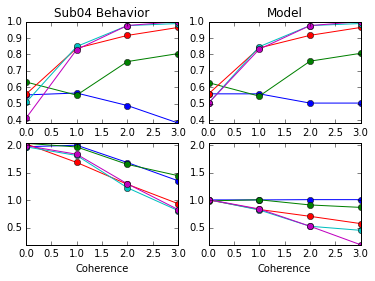

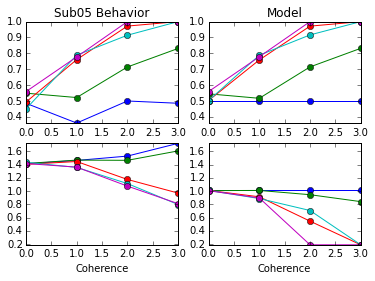

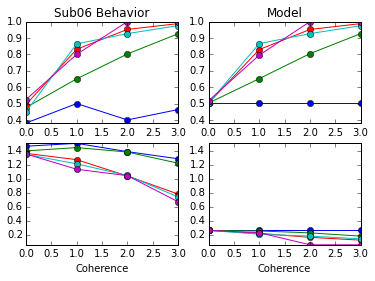

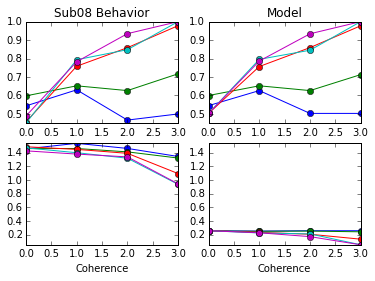

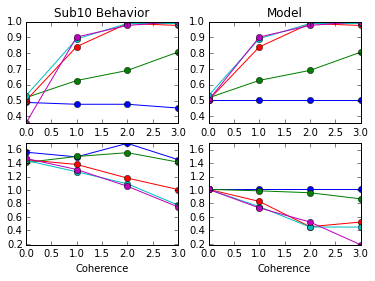

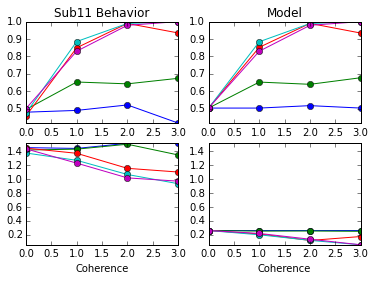

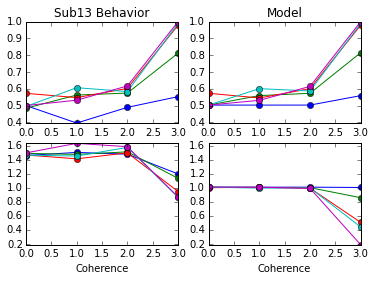

In [35]:
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(20):
        temp.append(epc[maxParId[si], bestx[cdi,si], cdi, si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(4,5)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(4,5)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(20):
        temp.append(ert[maxParId[si], bestx[cdi,si], cdi, si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(4,5)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(4,5)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')

In [36]:
minA = np.zeros(nSub)
maxA = np.zeros(nSub)
mink = np.zeros(nSub)
maxk = np.zeros(nSub)
mintR = np.zeros(nSub)
maxtR = np.zeros(nSub)

nd = 3 # Number of deltas before and after best fit value

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA[si] = As[maxParId[si]] - nd * dA
    maxA[si] = As[maxParId[si]] + nd * dA
    # if minA[si] < 0:
    #    minA[si] = A[0]
    
    mink[si] = ks[maxParId[si]] - nd * dk
    maxk[si] = ks[maxParId[si]] + nd * dk
    # if mink[si] < 0:
    #    mink[si] = k[0]
        
    mintR[si] = tRs[maxParId[si]] - nd * dtR
    maxtR[si] = tRs[maxParId[si]] + nd * dtR
    # if mintR[si] < 0:
    #    mintR[si] = tR[0]

In [37]:
print(minA.round(decimals=3))
print(maxA.round(decimals=3))
print(mink.round(decimals=3))
print(maxk.round(decimals=3))
print(mintR.round(decimals=3))
print(maxtR.round(decimals=3))

[-0.5 -0.5 -0.5 -0.5 -1.  -1.  -0.5 -1.  -0.5]
[ 2.5  2.5  2.5  2.5  2.   2.   2.5  2.   2.5]
[-1.099 -1.099 -1.099 -1.099 -0.544 -0.544 -1.099 -0.544 -1.099]
[ 2.228  2.228  2.228  2.228  2.782  2.782  2.228  2.782  2.228]
[-1.567 -1.567 -1.567 -1.567 -1.567 -1.567 -1.567 -1.567 -1.567]
[ 1.587  1.587  1.587  1.587  1.587  1.587  1.587  1.587  1.587]


In [38]:
nStep = 9 # Number of values tested, per parameter

A = np.zeros((nStep, nSub))
dA = np.zeros(nSub)
k = np.zeros((nStep, nSub))
dk = np.zeros(nSub)
tR = np.zeros((nStep, nSub))
dtR = np.zeros(nSub)

# This is the overall number of permutations of A, k and tR being performed
nPar = nStep ** 3

As = np.zeros((nPar, nSub))
ks = np.zeros((nPar, nSub))
tRs = np.zeros((nPar, nSub))

for si in range(nSub):
    A[:,si], dA[si] = np.linspace(minA[si], maxA[si], nStep, retstep=True)
    k[:,si], dk[si] = np.linspace(mink[si], maxk[si], nStep, retstep=True)
    tR[:,si], dtR[si] = np.linspace(mintR[si], maxtR[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A[:,si], k[:,si], tR[:,si])
    As[:,si] = tempAs.flatten()
    ks[:,si] = tempks.flatten()
    tRs[:,si] = temptRs.flatten()
    
    # Initialize arrays that hold predicted accuracies and RTs
    epc = np.ones((nPar, 20, 9)) * -9
    ert = np.ones((nPar, 20, 9)) * -9
    sdrt = np.ones((nPar, 20, 9)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc = np.zeros((nPar, 20, 9))
    lrt = np.zeros((nPar, 20, 9))

In [39]:
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(20):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,cdi,si] = 1 / (1 + np.exp(-2 * As[pi,si] * ks[pi,si] * abs(x[bestx[cdi,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc[pi,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,cdi,si] = As[pi,si] / (ks[pi,si] * x[bestx[cdi,si]]) * \
                                np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) + tRs[pi,si] 
            # Calculate SD of mean RT 
            sdrt[pi,cdi,si] = np.sqrt(((As[pi,si] * np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) - \
                    As[pi,si] * ks[pi,si] * x[bestx[cdi,si]] * \
                    (1/np.cosh(np.square(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]])))) / \
                    (ks[pi,si] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * tRs[pi,si])) / Ns[cdi,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt[pi,cdi,si] = 1 / (sdrt[pi,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,cdi,si] - mRTs[cdi,si]) / sdrt[pi,cdi,si]))

In [46]:
#maxLLcd = np.ones((nPar, 20, nSub)) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # maxLLcd[pi,:,si] = np.argmax(lpc[pi,:,:,si]+lrt[pi,:,:,si],0)
        for cdi in range(20):
            totLL[pi,si] += np.log(lpc[pi,cdi,si])

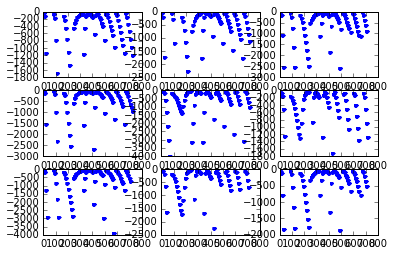

In [47]:
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')

In [49]:
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

for si in range(nSub):
    ids = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    if len(ids) > 1:
        maxParId[si] = ids[0]
    else:
        maxParId[si] = ids
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])

In [50]:
for si in range(nSub):
    print(totLL[maxParId[si],si])

-42.0096927229
-37.4377349821
-38.9513345283
-34.9684269071
-38.625439254
-40.0401738274
-37.8359732609
-37.8735329826
-43.2867434739


In [51]:
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si],si],ndigits=3), round(ks[maxParId[si],si],ndigits=3), \
          round(tRs[maxParId[si],si],ndigits=3))
    # print(np.reshape(maxLLcd[maxParId[si],:,si],(4,5)))

(1.0, 0.564, -1.567)
(1.0, 0.564, -1.567)
(1.0, 0.564, -1.567)
(1.0, 0.564, -1.567)
(0.5, 1.119, -1.567)
(0.5, 1.119, -1.567)
(1.0, 0.564, -1.567)
(0.5, 1.119, -1.567)
(1.0, 0.564, -1.567)


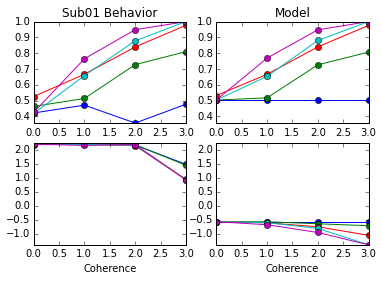

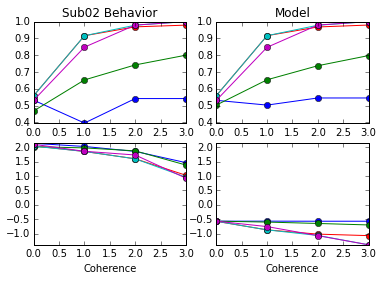

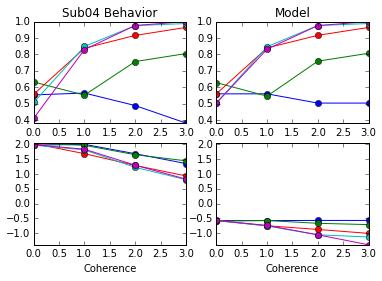

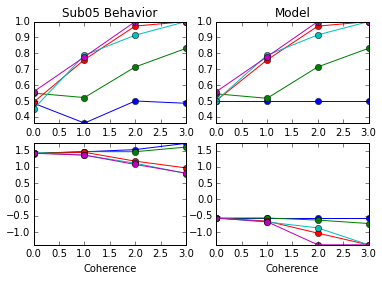

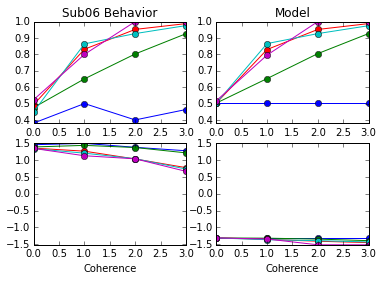

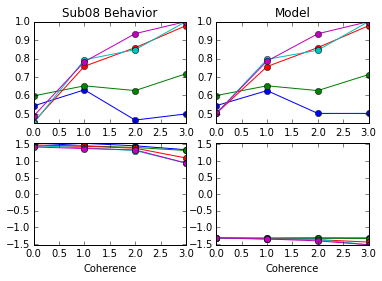

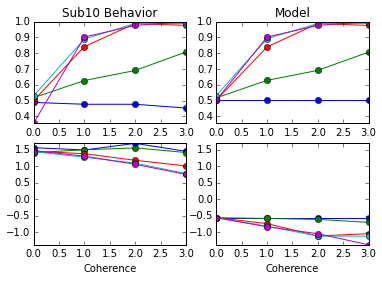

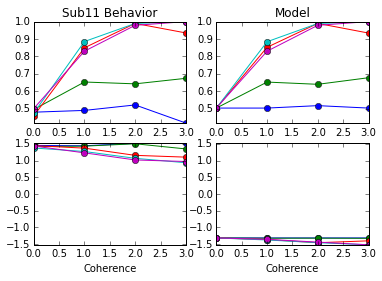

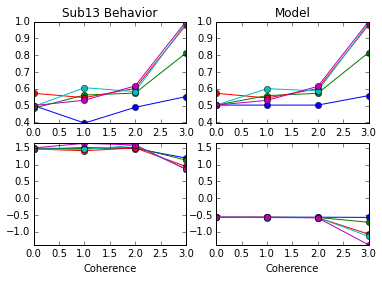

In [52]:
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(20):
        temp.append(epc[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(4,5)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(4,5)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(20):
        temp.append(ert[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(4,5)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(4,5)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')

[-0.208 -3.542 -0.208 -0.208 -0.208 -0.208 -0.208 -0.208 -2.708]
[ 3.542  0.208  3.542  3.542  3.542  3.542  3.542  3.542  1.042]
[-1.319 -2.431 -1.319 -1.319 -1.319 -1.319 -1.319 -1.319 -2.986]
[ 2.431  1.319  2.431  2.431  2.431  2.431  2.431  2.431  0.764]
[-1.344 -0.844 -1.344 -1.344 -1.844 -1.844 -1.344 -1.344 -0.344]
[ 0.344  0.844  0.344  0.344 -0.156 -0.156  0.344  0.344  1.344]
-72.9776497231
-58.9924201627
-52.4466343005
-64.6882004675
-62.1555503793
-67.6226786555
-59.2254834014
-64.8433789696
-67.0734028389
(1.667, 0.556, -0.5)
(-1.667, -0.556, 0.0)
(1.667, 0.556, -0.5)
(1.667, 0.556, -0.5)
(1.667, 0.556, -1.0)
(1.667, 0.556, -1.0)
(1.667, 0.556, -0.5)
(1.198, 0.556, 0.133)
(-0.833, -1.111, 0.5)


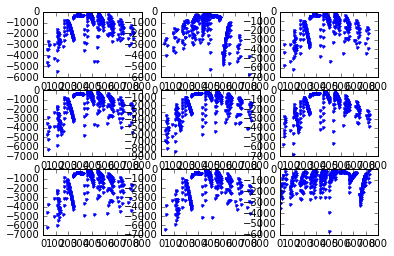

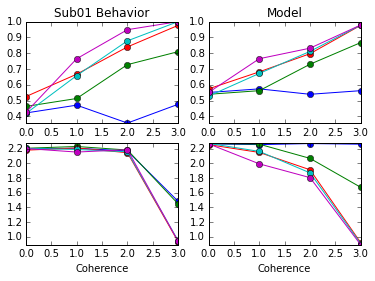

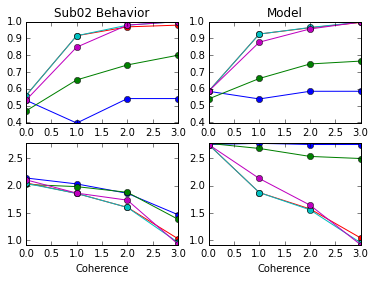

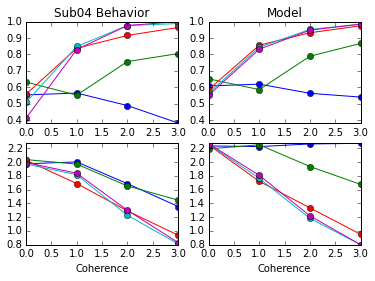

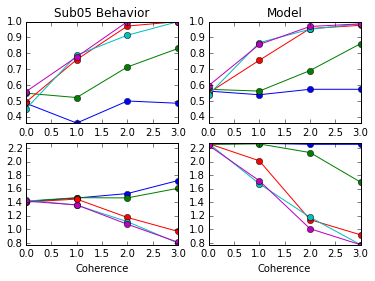

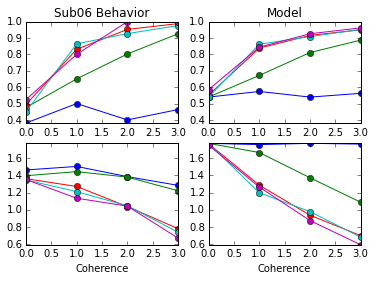

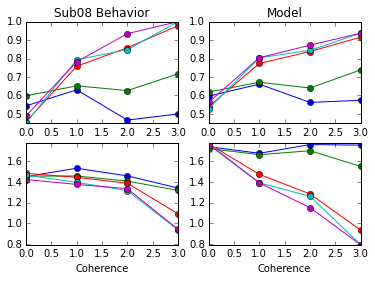

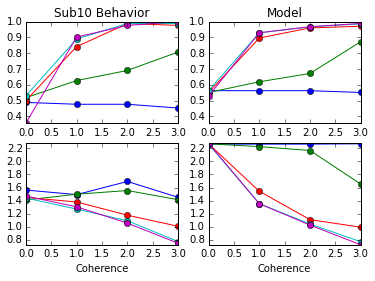

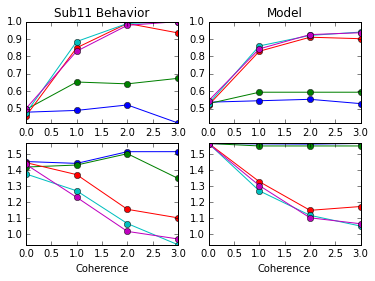

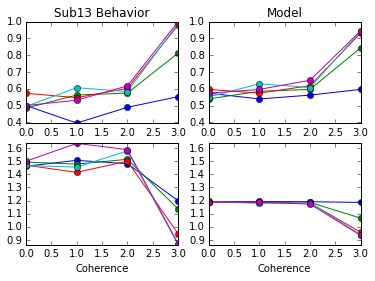

In [23]:
minA = np.zeros(nSub)
maxA = np.zeros(nSub)
mink = np.zeros(nSub)
maxk = np.zeros(nSub)
mintR = np.zeros(nSub)
maxtR = np.zeros(nSub)

for si in range(nSub):
    # Set up A, k and tR parameters for the next round of simulations
    # Use the bestx values from the first run, don't fit for x again
    
    # First set the range of all variables. 
    # minVar = bestValue - dVar*nd : bestValue + dVar*nd
    # If the new minimum is <= 0, then set it to the old minimum.
    minA[si] = As[maxParId[si],si] - nd * dA[si]
    maxA[si] = As[maxParId[si],si] + nd * dA[si]
    # if minA[si] < 0:
    #    minA[si] = A[0,si]
    
    mink[si] = ks[maxParId[si],si] - nd * dk[si]
    maxk[si] = ks[maxParId[si],si] + nd * dk[si]
    # if mink[si] < 0:
    #    mink[si] = k[0,si]
        
    mintR[si] = tRs[maxParId[si],si] - nd * dtR[si]
    maxtR[si] = tRs[maxParId[si],si] + nd * dtR[si]
    # if mintR[si] < 0:
    #    mintR[si] = tR[0,si]

print(minA.round(decimals=3))
print(maxA.round(decimals=3))
print(mink.round(decimals=3))
print(maxk.round(decimals=3))
print(mintR.round(decimals=3))
print(maxtR.round(decimals=3))

A = np.zeros((nStep, nSub))
dA = np.zeros(nSub)
k = np.zeros((nStep, nSub))
dk = np.zeros(nSub)
tR = np.zeros((nStep, nSub))
dtR = np.zeros(nSub)

As = np.zeros((nPar, nSub))
ks = np.zeros((nPar, nSub))
tRs = np.zeros((nPar, nSub))

for si in range(nSub):
    A[:,si], dA[si] = np.linspace(minA[si], maxA[si], nStep, retstep=True)
    k[:,si], dk[si] = np.linspace(mink[si], maxk[si], nStep, retstep=True)
    tR[:,si], dtR[si] = np.linspace(mintR[si], maxtR[si], nStep, retstep=True)

    tempAs, tempks, temptRs = np.meshgrid(A[:,si], k[:,si], tR[:,si])
    As[:,si] = tempAs.flatten()
    ks[:,si] = tempks.flatten()
    tRs[:,si] = temptRs.flatten()

    # Initialize arrays that hold predicted accuracies and RTs
    epc = np.ones((nPar, 20, 9)) * -9
    ert = np.ones((nPar, 20, 9)) * -9
    sdrt = np.ones((nPar, 20, 9)) * -9

    ## Initialize the array that holds the
    # individual likelihood values
    lpc = np.zeros((nPar, 20, 9))
    lrt = np.zeros((nPar, 20, 9))
    
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(20):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,cdi,si] = 1 / (1 + np.exp(-2 * As[pi,si] * ks[pi,si] * abs(x[bestx[cdi,si]])))

            # Calculate likelihood of accuracy for this CD combination
            lpc[pi,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,cdi,si] = As[pi,si] / (ks[pi,si] * x[bestx[cdi,si]]) * \
                                np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) + tRs[pi,si] 
            # Calculate SD of mean RT 
            sdrt[pi,cdi,si] = np.sqrt(((As[pi,si] * np.tanh(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]]) - \
                    As[pi,si] * ks[pi,si] * x[bestx[cdi,si]] * \
                    (1/np.cosh(np.square(As[pi,si] * ks[pi,si] * x[bestx[cdi,si]])))) / \
                    (ks[pi,si] * x[bestx[cdi,si]]) ** 3 + np.square(0.1 * tRs[pi,si])) / Ns[cdi,si])
            # Calculate likelihood of mean RT for this CD combination
            lrt[pi,cdi,si] = 1 / (sdrt[pi,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,cdi,si] - mRTs[cdi,si]) / sdrt[pi,cdi,si]))
                
#maxLLcd = np.ones((nPar, 20, nSub)) * -9
totLL = np.zeros((nPar, nSub))

for si in range(nSub):
    for pi in range(nPar):
        # maxLLcd[pi,:,si] = np.argmax(lpc[pi,:,:,si]+lrt[pi,:,:,si],0)
        for cdi in range(20):
            totLL[pi,si] += np.log(lpc[pi,cdi,si]) + \
                                np.log(lrt[pi,cdi,si])
                
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

for si in range(nSub):
    maxParId[si] = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    # print(np.where(maxLLx[:,si] == np.nanmax(maxLLx[:,si]))[0])
    
for si in range(nSub):
    print(totLL[maxParId[si],si])
    
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si],si],ndigits=3), round(ks[maxParId[si],si],ndigits=3), \
          round(tRs[maxParId[si],si],ndigits=3))
    # print(np.reshape(maxLLcd[maxParId[si],:,si],(4,5)))
    
# Plot the observed (behavior) and expected (model) PC and RT
for si in range(nSub):
    temp = []
    ymin = min(pCs[:,si])
    ymax = max(pCs[:,si])
    for cdi in range(20):
        temp.append(epc[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si] + ' Behavior')
    plt.plot(np.reshape(pCs[:,si],(4,5)),'o-')
    plt.ylim((ymin, ymax))
    
    plt.subplot(222)
    plt.title('Model')
    plt.plot(np.reshape(temp,(4,5)),'o-')
    plt.ylim((ymin,ymax))

    temp = []
    ymin = min(mRTs[:,si])
    ymax = max(mRTs[:,si])
    for cdi in range(20):
        temp.append(ert[maxParId[si],cdi,si])
    if min(temp) < ymin:
        ymin = min(temp)
    if max(temp) > ymax:
        ymax = max(temp)
    
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[:,si],(4,5)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')
    
    plt.subplot(224)
    plt.plot(np.reshape(temp,(4,5)),'o-')
    plt.ylim((ymin,ymax))
    plt.xlabel('Coherence')